In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from einops import rearrange, reduce, repeat
import serial
import scipy
from IPython.display import HTML
import time
from tqdm.notebook import tqdm

np.set_printoptions(precision=4, suppress=True)

In [2]:
def carrier(t, f, power):
    """
    Generate a carrier signal with a given frequency and power.
    :param t: time (s)
    :param f: frequency (Hz)
    :param power: power (dBm)
    """
    return np.sqrt(10 ** (power / 10)) * np.cos(2 * np.pi * f * t)


def fm_modulate(t, f_carrier, f_modulate, power, deviation):
    """
    Generate a frequency modulated signal with a given carrier frequency, modulation frequency, power and deviation.
    :param t: time (s)
    :param f_carrier: carrier frequency (Hz)
    :param f_modulate: modulation frequency (Hz)
    :param power: power (dBm)
    :param deviation: frequency deviation (Hz)
    """
    # FIXME: This is not the correct formula for FM modulation
    return np.sqrt(10 ** (power / 10)) * np.cos(
        2 * np.pi * f_carrier * t + 2 * np.pi * deviation * np.sin(2 * np.pi * f_modulate * t)
    )

def am_modulate(t, f_carrier, f_modulate, power, depth):
    """
    Generate an amplitude modulated signal with a given carrier frequency, modulation frequency, power and deviation.
    :param t: time (s)
    :param f_carrier: carrier frequency (Hz)
    :param f_modulate: modulation frequency (Hz)
    :param power: power (dBm)
    :param deviation: amplitude deviation (Hz)
    """
    return np.sqrt(10 ** (power / 10)) * (
        1 + depth * np.cos(2 * np.pi * f_modulate * t)
    ) * np.cos(2 * np.pi * f_carrier * t)

def noise(t, power):
    """
    Generate a noise signal with a given power.
    :param t: time (s)
    :param power: power (dBm)
    """
    return np.sqrt(10 ** (power / 10)) * np.random.normal(0, 1, len(t))

def sample_time(points, sample_rate):
    """
    Generate a time array with a given number of points and sample rate.
    :param points: number of points
    :param sample_rate: sample rate (Hz)
    """
    return np.linspace(0, points / sample_rate, points)

Peak frequency: 2001953.125


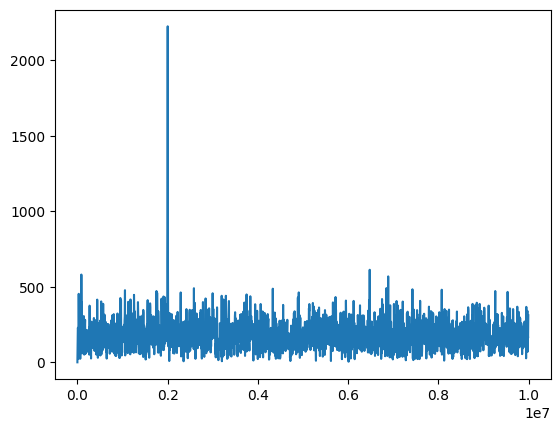

In [3]:
def plot_spectrum(data, points, sample_rate):
    data = data - np.mean(data)
    spec = np.fft.fft(data)
    amp = np.abs(spec)
    freq = np.fft.fftfreq(len(spec), 1 / sample_rate)
    plt.plot(freq[:points//2], amp[:points//2])
    print(f"Peak frequency: {np.abs(freq[np.argmax(amp)])}")

t = sample_time(4096, 20e6)
# signal = fm_modulate(t, 2e6, 1e3, 0, 15e3)
# plot_spectrum(signal, 4096, 20e6)
plt.show()
signal = am_modulate(t, 2e6, 1e3, 0, 0.5) + noise(t, 10)
plot_spectrum(signal, 4096, 20e6)
plt.show()

In [4]:
def get_peak_frequency(signal, sample_rate):
    """Get the peak frequency of a signal."""
    # add hamming window
    signal = signal * np.hanning(len(signal))
    fft = np.abs(np.fft.fft(signal))
    freqs = np.fft.fftfreq(len(fft), 1 / sample_rate)
    return np.abs(freqs[np.argmax(fft)])

  0%|          | 0/400 [00:00<?, ?it/s]

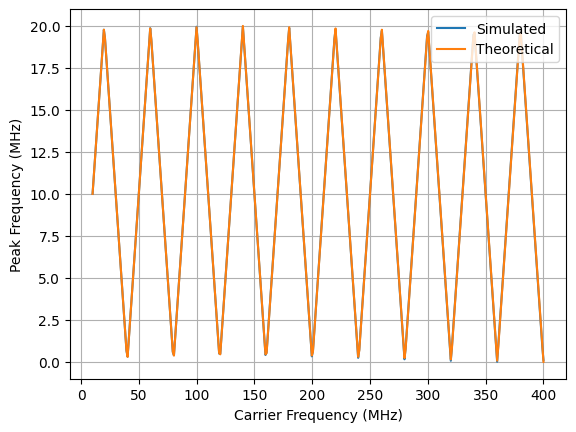

In [5]:
def get_bandpass_peak(f_sample, f_carrier):
    return f_sample / 2 - np.abs((f_carrier % f_sample) - f_sample / 2)


# do a bandpass sampling on the signal

carriers = np.linspace(10e6, 400e6, 400, dtype=np.float64)
sample_rate = 40e6
points = 4096
t = sample_time(points, sample_rate)
peak_frequency = np.zeros_like(carriers)
for i in tqdm(range(len(carriers))):
    signal = carrier(t, carriers[i], 0) + noise(t, -10)
    peak_frequency[i] = get_peak_frequency(signal, sample_rate)
plt.plot(carriers / 1e6, peak_frequency / 1e6, label="Simulated")
plt.plot(
    carriers / 1e6, get_bandpass_peak(sample_rate, carriers) / 1e6, label="Theoretical"
)
plt.xlabel("Carrier Frequency (MHz)")
plt.ylabel("Peak Frequency (MHz)")
plt.legend()
plt.grid()
plt.show()

In [6]:
def mod_l2_norm(base, x, y):
    dist = np.minimum((x - y) % base, (y - x) % base)
    return np.sum(dist**2)


def get_peak_at_sample_rate(f_sample, f_carrier):
    t = sample_time(8192, f_sample)
    # signal = carrier(t, f_carrier, 0) + noise(t, -10)
    signal = am_modulate(t, f_carrier, 1e3, 0, 1) + noise(t, 10)
    # signal = fm_modulate(t, f_carrier, 1e3, 0, 10e3) + noise(t, -10)
    return get_peak_frequency(signal, f_sample)


def detect_carrier_frequency_iteration(bases, base_coord, start, end, step):
    candidates = np.arange(start, end, step, dtype=np.float64)
    candidate_norm = np.zeros_like(candidates)
    for i in range(len(candidates)):
        candidate_coord = get_bandpass_peak(bases, candidates[i])
        candidate_norm[i] = mod_l2_norm(bases / 2, base_coord, candidate_coord)
    return candidates[np.argmin(candidate_norm)]


def detect_carrier_frequency(bases, base_coord):
    rough = detect_carrier_frequency_iteration(bases, base_coord, 5e6, 410e6, 0.1e6)
    return detect_carrier_frequency_iteration(bases, base_coord, rough - 0.2e6, rough + 0.2e6, 0.01e6)

def test_carrier_frequency(bases, f_carrier):
    # add some noise to base
    bases = bases.copy() + np.random.normal(0, 100, bases.shape)
    base_coord = np.zeros_like(bases)
    for i in range(len(bases)):
        base_coord[i] = get_peak_at_sample_rate(bases[i], f_carrier)
    return detect_carrier_frequency(bases, base_coord)

In [7]:
bases = np.array([43, 47, 53, 59], dtype=np.float64) * 1e6
f_carrier = 34e6
real_result = get_bandpass_peak(bases, f_carrier)
print(real_result / 1e6)

base_result = np.zeros_like(bases)
for i in range(len(bases)):
    base_result[i] = get_peak_at_sample_rate(bases[i], f_carrier)
print(base_result / 1e6)  
mod_l2_norm((bases / 2) / 1e6, base_result / 1e6, real_result / 1e6)

[ 9. 13. 19. 25.]
[ 8.9968 12.995  18.9951 24.9987]


6.076693534851074e-05

In [8]:
test_carrier_frequency(bases, f_carrier)

34000000.0

In [9]:
carriers = np.random.randint(10e6, 400e6, 100).astype(np.float64)
errors = np.zeros(carriers.shape, dtype=np.float64)
for i in tqdm(range(len(carriers))):
    errors[i] = test_carrier_frequency(bases, carriers[i])
errors = np.abs(errors - carriers)
print("Mean error: ", np.mean(errors) / 1e6)
print("Max error: ", np.max(errors) / 1e6)

  0%|          | 0/100 [00:00<?, ?it/s]

Mean error:  0.02475475
Max error:  0.050885


In [10]:
def read_data_csv(file_name):
    data = np.genfromtxt(file_name, delimiter=",", skip_header=2, usecols=3).astype(
        np.float64
    )
    data = data[:4096] / 32768.0
    return data


base_int = [53, 57, 61, 67]
bases = np.array(base_int, dtype=np.float64) * 1e6
base_coords = np.zeros_like(bases)
for i in range(len(bases)):
    base_coords[i] = get_peak_frequency(
        read_data_csv(f"385-{base_int[i]}sps.csv"), bases[i]
    )
detect_carrier_frequency(bases, base_coords)

384750000.0

In [11]:
detect_carrier_frequency(
    np.array([43, 47, 53, 59], dtype=np.float64) * 1e6,
    np.array([1.71, 14.98, 20.14, 26.83], dtype=np.float64) * 1e6,
)

389250000.0

In [92]:
bases = np.arange(20, 31, 1)
m = np.sum(bases)
n = m


def generate_matrix(bases, n):
    m = np.sum(bases)
    A = np.zeros((m, n))
    i_tot = 0
    for i in range(len(bases)):
        for j in range(n):
            pos = j % (bases[i] * 2)
            if pos >= bases[i]:
                pos = 2 * bases[i] - pos - 1
            A[i_tot + pos, j] = 1
        i_tot += bases[i]
    return A

k = n
while k > 0:
    A = generate_matrix(bases, k)
    if np.linalg.matrix_rank(A) == k:
        break
    k -= 1
print(k)
print(np.linalg.cond(A.T @ A))

230
8.232553265229475e+16


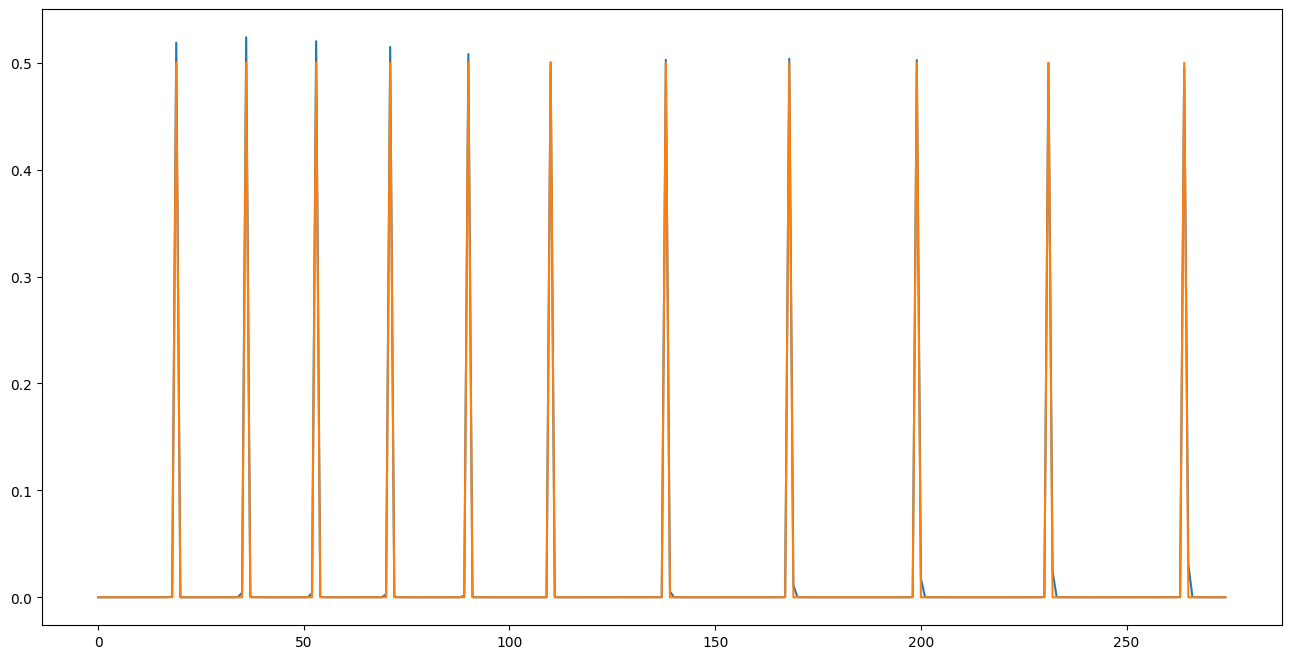

In [103]:
def sample_for_base(base):
    n = base * 20
    t = sample_time(n, base * 2e6).astype(np.float64)
    # signal = carrier(t, 100e6, 0) + carrier(t, 333e6, -5) + noise(t, -20)
    signal = carrier(t, 100e6, 0)
    signal = signal * np.hanning(n)
    fft = np.abs(np.fft.fft(signal)[0:n//2]) / n
    fft = reduce(fft, '(n s) -> n', 'sum', s=10)
    return fft

b = np.empty(0, dtype=np.float64)
b1 = np.zeros(m, dtype=np.float64)
i_tot = 0
for i in range(len(bases)):
    b = np.append(b, sample_for_base(bases[i]))
    pos = 100 % (bases[i] * 2)
    if pos >= bases[i]:
        pos = 2 * bases[i] - pos - 1
    b1[i_tot + pos] = 1
    i_tot += bases[i]

plt.figure(figsize=(16, 8))
plt.plot(b)
plt.plot(b1 * 0.5)

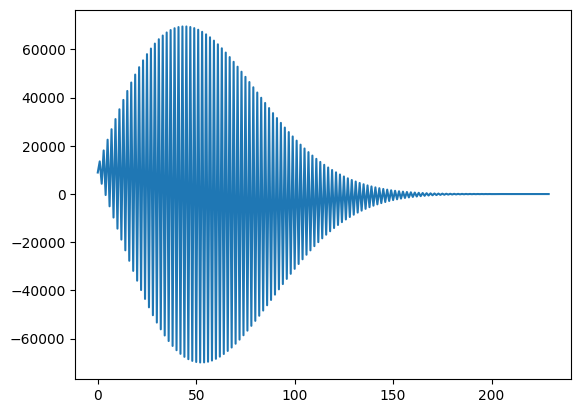

In [108]:
x_proj = np.linalg.solve(A.T @ A, A.T @ b)
plt.plot(x_proj)

C:\Users\duanyll\AppData\Local\Temp\ipykernel_36052\766906757.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_qr = np.linalg.lstsq(A, b)[0]


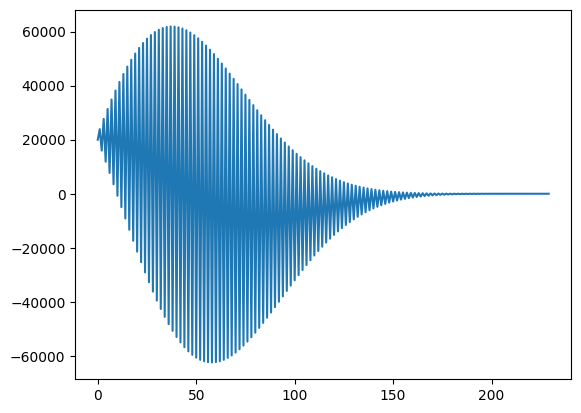

In [106]:
x_qr = np.linalg.lstsq(A, b)[0]
plt.plot(x_qr, label='QR')